## Importing libraries

For any issues running these modules, use python -m pip install -r requirements.txt

In [1]:
import librosa
import pandas as pd
import numpy as np
import sklearn

import os

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Load data, separate into train/test

In [2]:
from fractions import Fraction
import random

path = "./data/audio_speech_actors_01-24/"
actors = os.listdir(path)

# We need to categorize the data files according to their emotion. Since the dataset is labelled by emotion (which is encoded into their filenames), we need to break that down
# Filename identifiers:
# Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
#
# Vocal channel (01 = speech, 02 = song).
#
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
#
# Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
#
# Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
#
# Repetition (01 = 1st repetition, 02 = 2nd repetition).
#
# Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

# We are only focusing on the emotion, so we categorize by the third number (01-08)
# according to the dataset's site
mapping = {1:"neutral", 2:"calm", 3:"happy", 4:"sad", 5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"}

def load_data(path, return_train_test=False, test_percentage=0.20):
    # 1 slot for each of the emotions
    emot = []
    paths = []
    train_test_labels = []
    
    # Custom making our train/test split
    test_threshold = int(len(os.listdir(path)) * test_percentage + 1)    # (At least) 20% of data reserved for testing (important that we do this by actor to prevent data leakage)
    print("Test data is {:0.2f}% of the overall data".format(1 / (len(os.listdir(path))/test_threshold)))
    
    # Make a list of actors so we can shuffle order (last few actors will not always be test data each time we load data)
    actors = []
    for directory in os.listdir(path):
        actors.append(directory)
    random.shuffle(actors)
    
    count = 0
    data_label = "test"
    for directory in actors:
        count += 1
        if (count == test_threshold):
            data_label = "train"
        files = os.path.join(path, directory)
        for file in os.listdir(files):
            em_num = int(file.split("-")[2])
            emot.append(em_num)
            train_test_labels.append(data_label)
            paths.append(path + directory + "/" + file)
    
    tts = pd.DataFrame(train_test_labels, columns=["train_test"])
    ems = pd.DataFrame(emot, columns=['emotion']).replace(mapping)
    pths = pd.DataFrame(paths, columns = ["path"])
    data_file = pd.concat(
        [
            tts.reset_index(drop=True),
            ems.reset_index(drop=True),
            pths.reset_index(drop=True)
        ],
        axis=1,
    )
    
    if return_train_test:
        return get_train_test(data_file)
    return data_file

def get_train_test(data):
    grouped = data.groupby(data.train_test)
    train = grouped.get_group("train")
    test = grouped.get_group("test")
    return train, test

print("--- Building Train/Test Data ---")
data = load_data(path)
train, test = get_train_test(data)
train_size = train.train_test.value_counts().train
test_size = test.train_test.value_counts().test
print("Train has", train_size, "files.")
print("Test has", test_size, "files.")

ratio = Fraction(train_size, test_size)
print("Split is", str(ratio.numerator)+":"+str(ratio.denominator), "train:test")

--- Building Train/Test Data ---
Test data is 0.21% of the overall data
Train has 1200 files.
Test has 240 files.
Split is 5:1 train:test


## Extract data

In [3]:
import numpy as np

X = []
y = []

# for m in mapping:
#     for i in train[m]:
#         X.append(i)
#         y.append(m)

def gen_mfccs(data, NUM_MFCCs=13):
    mfccs = pd.DataFrame(columns=['mfccs'])
    
    # Get mfccs from each audio file
    count=0
    for i, j in data.iterrows():
        for item in j.items():
            if item[0] == 'path':
                # Sample rate and duration taken from the kaggle dataset description
                file, sample_rate = librosa.load(item[1], res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
                sample_rate = np.array(sample_rate)
                mfcc = np.mean(librosa.feature.mfcc(y=file, sr=sample_rate, n_mfcc=NUM_MFCCs), axis=0)
                mfccs.loc[count] = [mfcc]
                count+=1
                break
    
    # Gen list of mfccs as a dataframe to **manually** concatenate onto data
#     mfccs = pd.DataFrame(mfccs, columns = [("mfcc_" + str(num)) for num in range(len(mfccs[0]))])
#     data = pd.concat(
#         [
#             data.reset_index(drop=True),
#             mfccs.reset_index(drop=True)
#         ],
#         axis=1
#     )

    # Add on these mfccs to the data DataFrame
    return pd.concat([data.reset_index(drop=True), pd.DataFrame(mfccs["mfccs"].values.tolist())], axis=1)
        
data = gen_mfccs(data)
data = data.fillna(0)
train, test = get_train_test(data)

# Save train + test DataFrame file as a csv
data.to_csv("extracted_data.csv",index=False)

In [4]:
def get_x_y(data):
    rev_mapping = {emotion: num for num, emotion in mapping.items()}
    x, y = [], []
    for i, j in data.iterrows():
        col = (label for label in j.items() if label[0] == 'emotion')
        for item in col:
            y.append(rev_mapping[item[1]])
        count = 0
        xs = []
        for k in j.items():
            if count > 5:
                xs.append(k[1])
            count += 1
        x.append(xs)
    return x, y

# The numbered columns are mfccs
print(train)
train_x, train_y = get_x_y(train)
test_x, test_y = get_x_y(test)

     train_test  emotion                                               path  \
240       train  fearful  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
241       train    angry  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
242       train    angry  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
243       train  fearful  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
244       train      sad  ./data/audio_speech_actors_01-24/Actor_02/03-0...   
...         ...      ...                                                ...   
1435      train  neutral  ./data/audio_speech_actors_01-24/Actor_22/03-0...   
1436      train     calm  ./data/audio_speech_actors_01-24/Actor_22/03-0...   
1437      train     calm  ./data/audio_speech_actors_01-24/Actor_22/03-0...   
1438      train    happy  ./data/audio_speech_actors_01-24/Actor_22/03-0...   
1439      train    happy  ./data/audio_speech_actors_01-24/Actor_22/03-0...   

              0          1          2          3   

## Baselines

In [5]:
from sklearn.dummy import DummyClassifier

# train a dummy classifier to make predictions based on the most_frequent class value
frequent_dummy_classifier = DummyClassifier(strategy="most_frequent")
frequent_dummy_classifier.fit(train_x, train_y)

print("Highest frequency baseline:", frequent_dummy_classifier.score(test_x, test_y))

# train a dummy classifier to make predictions based on the class values
stratified_dummy_classifier = DummyClassifier(strategy="stratified")
stratified_dummy_classifier.fit(train_x,train_y)

print("Random baseline", stratified_dummy_classifier.score(test_x, test_y))

# train a dummy classifier to make predictions based on uniform selection
uniform_dummy_classifier = DummyClassifier(strategy="uniform")
uniform_dummy_classifier.fit(train_x,train_y)

print("Random uniform baseline", uniform_dummy_classifier.score(test_x, test_y))

Highest frequency baseline: 0.13333333333333333
Random baseline 0.12083333333333333
Random uniform baseline 0.17083333333333334


## Plot Data

Visualize the data that we have extracted to better understand trends to expect and routes to go for changing parameters.

Text(0, 0.5, 'yLabel')

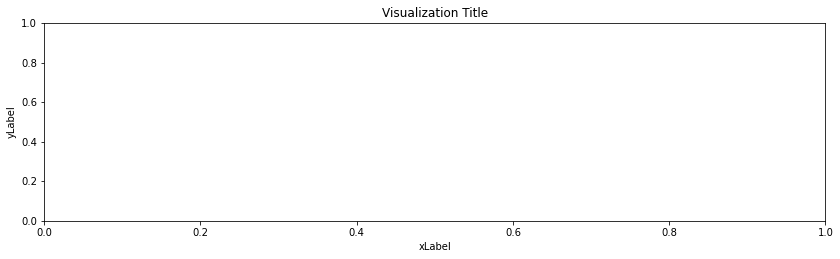

In [6]:
## TO DO
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Visualization Title')
ax1.set_xlabel('xLabel')
ax1.set_ylabel('yLabel')

## Data preparation

If we want to transform the data in any way, we can do it here.

In [8]:
train_length = len(train_x[0])
train_x = np.array(train_x).reshape(-1,train_length,1)
print(np.shape(train_x))
print(train_x[0])
print()


test_length = len(test_x[0])
test_x = np.array(test_x).reshape(-1,test_length,1)
print(np.shape(test_x))
print(test_x[0])


# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()


# # 
# # Generates an int for each label
# y=le.fit_transform(labels)

# # Prints out each date with its int mapping
# for c in list(le.classes_):
#     print(le.transform([c])[0], c)

(1200, 213, 1)
[[-56.68172455]
 [-56.78448105]
 [-55.85403061]
 [-55.72322083]
 [-56.15439224]
 [-55.49872208]
 [-53.93239594]
 [-54.44218445]
 [-54.94053268]
 [-55.65406799]
 [-55.58727646]
 [-55.43637848]
 [-54.70941925]
 [-54.01356506]
 [-54.58927155]
 [-54.90510941]
 [-55.49765778]
 [-56.95895767]
 [-58.11436081]
 [-58.26810074]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-58.26529312]
 [-56.07157898]
 [-53.89182281]
 [-54.97628021]
 [-54.32460785]
 [-48.91162491]
 [-38.06649017]
 [-36.1774025 ]
 [-38.18199921]
 [-39.871521  ]
 [-40.43122864]
 [-39.43253708]
 [-39.72987747]
 [-41.036129  ]
 [-41.92995453]
 [-41.69484711]
 [-40.30969238]
 [-39.76254654]
 [-42.42000961]
 [-40.48332214]
 [-40.49825287]
 [-41.55001068]
 [-42.27687454]
 [-39.40753174]
 [-40.98705673]
 [-44.185

In [9]:
import keras
from keras.utils import np_utils

labels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

train_y = [val-1 for val in train_y]
train_y = [int(val) for val in train_y]
print(train_y[0], labels[0])
train_y=np_utils.to_categorical(train_y, num_classes=len(labels), dtype=np.int32)
print(train_y[0], labels[0])

test_y = [val-1 for val in test_y]
print(test_y[0], labels[0])
test_y=np_utils.to_categorical(test_y, num_classes=len(labels), dtype=np.int32)
print(test_y[0], labels[0])

5 neutral
[0 0 0 0 0 1 0 0] neutral
0 neutral
[1 0 0 0 0 0 0 0] neutral


## Initializing the model

In [10]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

print(type(train_y[0][0]))

<class 'numpy.int32'>


In [11]:
K.clear_session()

inputs = Input(shape=(train_length,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

# Output layer
outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 213, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 201, 8)            112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 67, 8)             0         
_________________________________________________________________
dropout (Dropout)            (None, 67, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 57, 16)            1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 16)           

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Training the model

In [13]:
history=model.fit(np.array(train_x), np.array(train_y), epochs=10, callbacks=[es,mc], batch_size=32, validation_data=(np.array(test_x),np.array(test_y)))
print("MODEL TRAINING COMPLETE!")

Epoch 1/10
36/38 [===========================>..] - ETA: 0s - loss: 3.2230 - accuracy: 0.1233
Epoch 00001: val_accuracy improved from -inf to 0.16250, saving model to best_model.hdf5
38/38 [==============================] - 0s 10ms/step - loss: 3.1790 - accuracy: 0.1233 - val_loss: 2.0705 - val_accuracy: 0.1625
Epoch 2/10
35/38 [==========================>...] - ETA: 0s - loss: 2.1002 - accuracy: 0.1509
Epoch 00002: val_accuracy did not improve from 0.16250
38/38 [==============================] - 0s 5ms/step - loss: 2.0988 - accuracy: 0.1525 - val_loss: 2.0648 - val_accuracy: 0.1458
Epoch 3/10
36/38 [===========================>..] - ETA: 0s - loss: 2.0749 - accuracy: 0.1345
Epoch 00003: val_accuracy improved from 0.16250 to 0.22917, saving model to best_model.hdf5
38/38 [==============================] - 0s 6ms/step - loss: 2.0758 - accuracy: 0.1342 - val_loss: 2.0570 - val_accuracy: 0.2292
Epoch 4/10
36/38 [===========================>..] - ETA: 0s - loss: 2.0818 - accuracy: 0.1415


## Post Visualization

Now we can take a look at how successful our model is and can easily find where overfitting takes place (if at all)

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='test') 
plt.legend() 
plt.show()

In [ ]:
# For the application part (maybe a separate file), we can use our model to predict the future performance

from keras.models import load_model
model=load_model('best_model.hdf5')